In [5]:
!pip install pm4py

In [6]:
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

In [7]:
log_csv = pd.read_csv('ArtificialPatientTreatment.csv')

log_csv

,patient,action,org:resource,DateTime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09
...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13


In [8]:
log_csv[' DateTime'] = pd.to_datetime(log_csv[' DateTime'])

log_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   patient        690 non-null    object        
 1    action        690 non-null    object        
 2    org:resource  690 non-null    object        
 3    DateTime      690 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 21.7+ KB


In [9]:
case_starts_ends = log_csv.pivot_table(index='patient', aggfunc={' DateTime': ['min', 'max']})

case_starts_ends

DateTime                    
                           max                 min
patient                                           
patient 0  2017-01-09 08:29:28 2017-01-02 11:40:11
patient 1  2017-01-06 16:49:21 2017-01-02 12:50:35
patient 10 2017-01-30 11:19:19 2017-01-17 14:13:17
patient 11 2017-02-02 10:13:13 2017-01-19 13:35:20
patient 12 2017-01-27 11:18:57 2017-01-20 11:43:38
...                        ...                 ...
patient 95 2017-05-26 10:19:34 2017-05-15 09:15:08
patient 96 2017-05-24 16:38:21 2017-05-15 10:31:45
patient 97 2017-05-22 14:37:56 2017-05-17 08:44:01
patient 98 2017-05-31 14:16:13 2017-05-17 10:56:48
patient 99 2017-05-31 12:46:43 2017-05-18 11:57:11

[100 rows x 2 columns]

In [10]:
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['patient', 'caseend', 'casestart']
# Merge with the main event log data so that for each row we have the start and end times.
log_csv = log_csv.merge(case_starts_ends, on='patient')
# Calculate the relative time by subtracting the process start time from the event timestamp
log_csv['relativetime'] = log_csv[' DateTime'] - log_csv['casestart']
# Convert relative times to more friendly measures
## seconds
log_csv['relativetime_s'] = log_csv['relativetime'].dt.seconds + 86400*log_csv['relativetime'].dt.days
## days
log_csv['relativedays'] = log_csv['relativetime'].dt.days

log_csv

,patient,action,org:resource,DateTime,caseend,casestart,relativetime,relativetime_s,relativedays
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3
...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11


In [11]:
log_csv['caselength'] = log_csv['caseend'] - log_csv['casestart']

log_csv

,patient,action,org:resource,DateTime,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17
...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32


In [12]:
log_csv.rename(columns=
                {' DateTime': 'time:timestamp',
                 'patient': 'case:concept:name',
                 ' action': 'concept:name',
                 ' org:resource': 'org:resource'},
                inplace=True)

log_csv

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17
...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32


In [13]:
event_log = log_converter.apply(log_csv)
type(event_log)


pm4py.objects.log.obj.EventLog

In [14]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.log import case_statistics

variants = variants_filter.get_variants(event_log)
print(f"У нас есть: {len(variants)} различных вариантов путей в нашем журнале событий")

У нас есть: 15 различных вариантов путей в нашем журнале событий


In [15]:
variants_count = case_statistics.get_variant_statistics(log_csv)

variants_count

[{'variant': (' First consult',
   ' Blood test',
   ' X-ray scan',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 18},
 {'variant': (' First consult',
   ' Blood test',
   ' Physical test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 14},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Physical test',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 12},
 {'variant': (' First consult',
   ' Physical test',
   ' X-ray scan',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 11},
 {'variant': (' First consult',
   ' Physical test',
   ' Blood test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 10},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Blood test',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 9},
 {'variant'

In [16]:
#1 Каково минимальное и максимальное количество событий в одном случае?
variants_count = case_statistics.get_variant_statistics(log_csv)
traces = []
for trace in variants_count:
  current = len(trace['variant'])
  traces.append(current)
minimal_elem = min(traces)
max_elem = max(traces)
print("Минимальное количество событий в случае: "+str(minimal_elem)+ "\n"+ "Максимальное количество событий в случае: "+str(max_elem))

Минимальное количество событий в случае: 6
Максимальное количество событий в случае: 7


In [17]:
#2 Какие события являются общими для всех процессов?
traces=[]
for trace in variants_count:
  traces.append(list(trace['variant']))
res = list(set.intersection(*map(set, traces)))
print ("Общие события для всех процессов : " + str(res))


Общие события для всех процессов : [' Physical test', ' Second consult', ' Blood test', ' Final consult', ' First consult']


In [18]:
#3 Найдите наибоее часто встречающуюся последовательность событий.
count_list =[]
res=[]
for variant in variants_count:
  count_list.append(variant['count'])
for variant in variants_count:
  if variant['count'] == max(count_list):
    res.append(variant['variant'])
res

[(' First consult',
  ' Blood test',
  ' X-ray scan',
  ' Physical test',
  ' Second consult',
  ' Medicine',
  ' Final consult')]

In [19]:
#4 Какой пациент на лечение тратил меньше всего времени, а какой больше?
case_starts_ends = log_csv.pivot_table(index='case:concept:name', aggfunc={'time:timestamp':['min','max']})
case_starts_ends[max]=pd.datetime.now()-case_starts_ends[max]
case_starts_ends[min]=pd.datetime.now()-case_starts_ends[min]
case_starts_ends['time']=case_starts_ends[max].dt.total_seconds()-case_starts_ends[min].dt.total_seconds()
case_starts_ends
del case_starts_ends['time:timestamp']
case_starts_ends
print("Максимальное время у "+str(
case_starts_ends[case_starts_ends['time']==case_starts_ends['time'].max()]))
print("Минимальное время у "+str(
case_starts_ends[case_starts_ends['time']==case_starts_ends['time'].min()]))

Максимальное время у                            time
                               
case:concept:name              
patient 47         1.478584e+06
Минимальное время у                            time
                               
case:concept:name              
patient 76         92043.998367


<ipython-input-19-11e27238416f>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  case_starts_ends[max]=pd.datetime.now()-case_starts_ends[max]
<ipython-input-19-11e27238416f>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  case_starts_ends[min]=pd.datetime.now()-case_starts_ends[min]


In [20]:
#5 Создать в DataFrame новую колонку, в которой будет записано количество событий для данного процесса (NumActions in Case)
log_csv.value_counts(subset=['case:concept:name'])

case:concept:name
patient 54           7
patient 75           7
patient 73           7
patient 72           7
patient 71           7
                    ..
patient 27           6
patient 29           6
patient 35           6
patient 42           6
patient 0            6
Length: 100, dtype: int64

In [21]:
#6 Pation 13 с каким врачом/врачами он/она консультировался?
pat13 = log_csv[log_csv['case:concept:name']=='patient 13']
pat13["org:resource"]

89         Dr. Bob
90          Team 2
91     Nurse Jesse
92             Lab
93        Dr. Anna
94        Pharmacy
95         Dr. Ben
Name: org:resource, dtype: object

In [22]:
#7 Какое событие является наиболее ресурсоёмким в данном журнале событий?

most = log_csv[log_csv['relativetime_s']==log_csv['relativetime_s'].max()]
most ['concept:name']

327     Final consult
Name: concept:name, dtype: object

In [23]:
#8 Есть ли врачи или медсестры, которые перегружены работой?

grouped_data = log_csv.groupby('org:resource').agg({'caselength': 'sum'})
print(grouped_data.nlargest(3, 'caselength'))

                     caselength
org:resource                   
 Dr. Anna    1549 days 23:50:20
 Lab          957 days 16:54:04
 Dr. Bob      867 days 09:46:35


In [24]:
#Задание 9:Какие мероприятия (actions) непропорционально отнимают время у некоторых врачей и медсестер? Каково распределение событий среди врачей и медсестер?
event_sorted_by_resource = log_csv.groupby('org:resource')['concept:name'].nunique()
total_events = event_sorted_by_resource.sum()
event_share_by_resource = event_sorted_by_resource / total_events
print(event_share_by_resource)

org:resource
 Dr. Alex       0.0625
 Dr. Anna       0.1875
 Dr. Ben        0.0625
 Dr. Bob        0.1250
 Dr. Charlie    0.0625
 Dr. Quinn      0.0625
 Dr. Rudy       0.0625
 Lab            0.0625
 Nurse Corey    0.0625
 Nurse Jesse    0.0625
 Pharmacy       0.0625
 Team 1         0.0625
 Team 2         0.0625
Name: concept:name, dtype: float64


In [39]:
#Задание 10: Какие события связаны с узкими местами и какие ресурсы задействованы?
import numpy as np
seconds_to_hours = 60*60
log_csv['diff'] = log_csv.groupby('case:concept:name')['time:timestamp'].diff(1)
log_csv['time'] = log_csv.groupby(['case:concept:name'])['diff'].shift(-1)
log_csv['time'] = log_csv['time'] / seconds_to_hours
log_csv.drop('diff', axis=1, inplace=True)

pd.pivot_table(log_csv,
               index=["concept:name", "org:resource"],
               values=["time"],
               aggfunc=np.sum
               )

time
concept:name    org:resource                          
 Blood test      Lab         0 days 01:20:33.284166625
 Final consult   Dr. Anna              0 days 00:00:00
                 Dr. Ben               0 days 00:00:00
 First consult   Dr. Anna    0 days 00:27:43.779166643
                 Dr. Bob     0 days 00:34:08.394166647
 Medicine        Pharmacy    0 days 01:08:27.125277737
 Physical test   Nurse Corey 0 days 00:30:37.866944428
                 Nurse Jesse 0 days 00:37:15.065277754
 Second consult  Dr. Anna    0 days 00:23:05.849166644
                 Dr. Bob     0 days 00:20:26.003055534
 Surgery         Dr. Alex    0 days 00:05:22.890277776
                 Dr. Charlie 0 days 00:03:52.926666664
                 Dr. Quinn   0 days 00:01:07.731111110
                 Dr. Rudy    0 days 00:05:37.135833330
 X-ray scan      Team 1      0 days 00:21:02.561944427
                 Team 2      0 days 00:23:44.288055534

In [31]:
#11.Постройте график/и распределения времени между первой консультацией и следующим действием пациента. Каково среднее время между первой консультацией и следующим шагом лечения? Каково максимальное и минимальное время?
from pm4py.objects.petri_net.utils.performance_map import mean
import pm4py
log_csv['num'] = log_csv.groupby('case:concept:name').cumcount()+1
tracefilter_log_pos = pm4py.filter_event_attribute_values(log_csv, 'num', [2], level="event", retain=True)

print("Среднее время между первой консультацией и следующим шагом лечения ", mean(tracefilter_log_pos['relativetime_s']))
print("Максимальное время ", max(tracefilter_log_pos['relativetime_s']))
print("Минимальное время ", min(tracefilter_log_pos['relativetime_s']))



Среднее время между первой консультацией и следующим шагом лечения  133638.24
Максимальное время  587118
Минимальное время  1324


In [23]:
#По имеющемуся набору данных постройте модель процессов используя различные алгоритмы обнаружения процесса: inductive miner, heuristics miner, Alpha Miner, DFG граф.

/usr/local/lib/python3.10/dist-packages/pm4py/utils.py:537: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

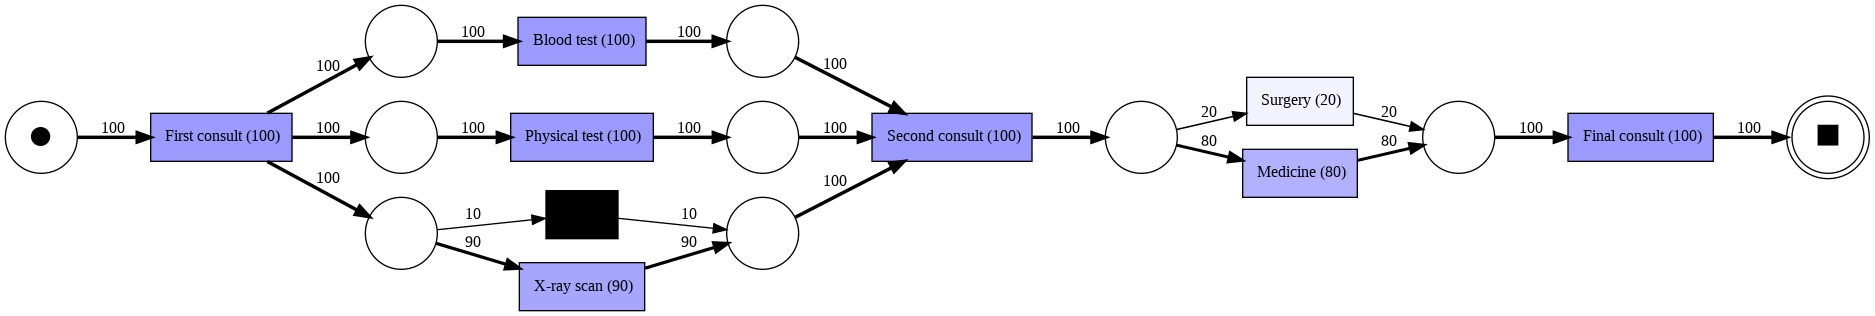

In [40]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
import pm4py
# net, im, fm = inductive_miner.apply(event_log)
net, im, fm = pm4py.discover_petri_net_inductive(event_log)
from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

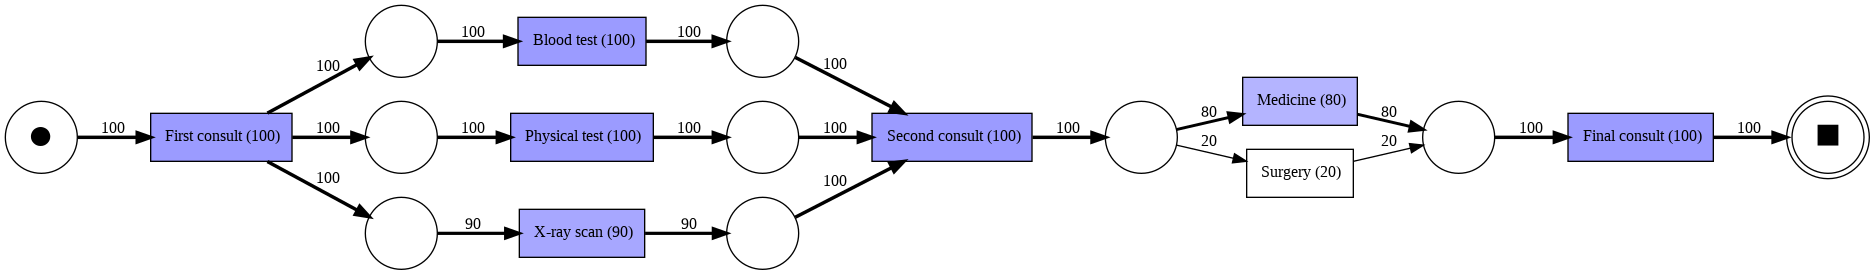

In [41]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
net, initial_marking, final_marking = heuristics_miner.apply(event_log)
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

gviz = pn_visualizer.apply(net, initial_marking,
                           final_marking,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)

pn_visualizer.view(gviz)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

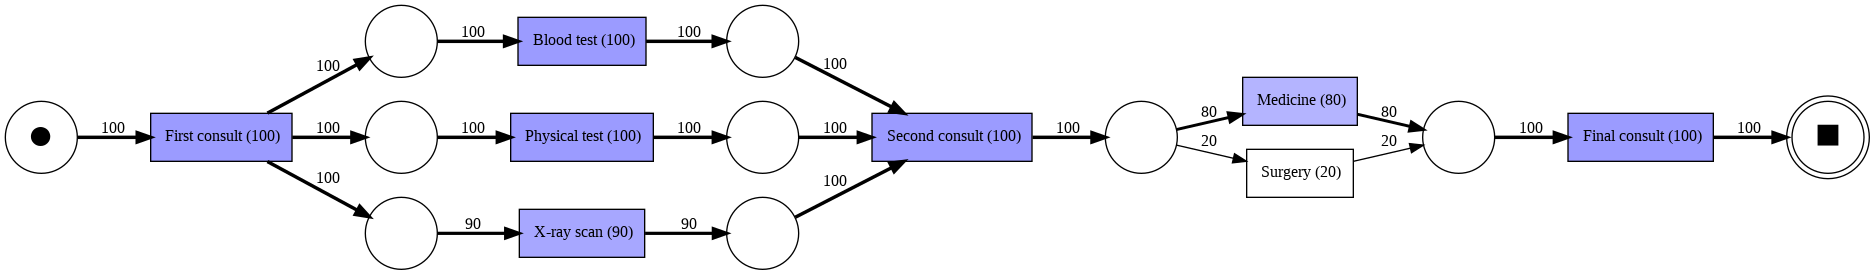

In [42]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

net, im, fm = alpha_miner.apply(event_log)
from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

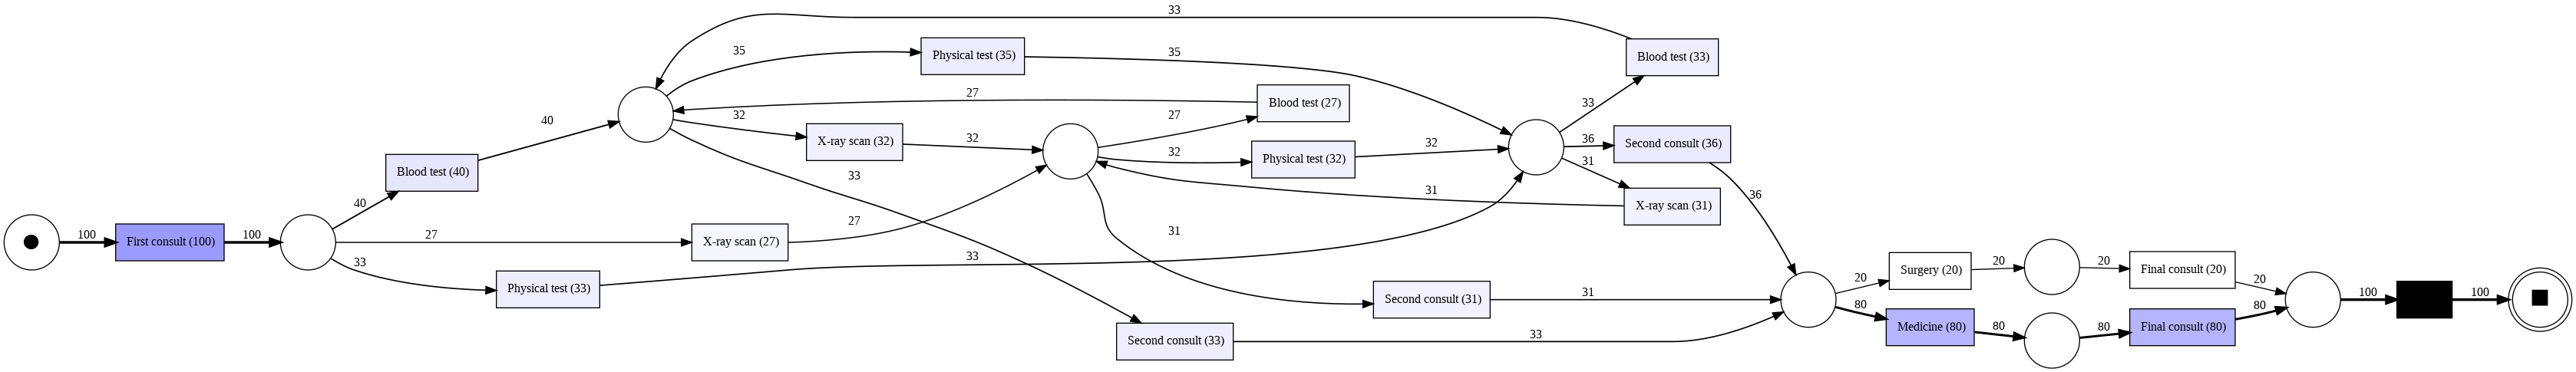

In [43]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
dfg = dfg_discovery.apply(event_log)
from pm4py.objects.conversion.dfg import converter as dfg_mining
net, im, fm = dfg_mining.apply(dfg)
from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz)